<a href="https://colab.research.google.com/github/TeresaKa/clustering_sose2020/blob/master/AutoEncoder(Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [87]:
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing import sequence
import random
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import unicodedata
import string
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Nadam
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import SGD, Adam
import warnings
warnings.filterwarnings('ignore')

In [88]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16702868944531276871
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14155751825071700783
physical_device_desc: "device: XLA_CPU device"
]


In [89]:
#df = pd.read_csv("/content/gdrive/Meine Ablage/Colab Notebooks/song_decades_long.csv")
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/song_decades_long.csv')

In [5]:
df.head(2)

,Unnamed: 0,artist,decades,text,stemmed_text,POS,Genre1,genre1,number_of_tokens,number_of_types
0,0,"""Weird Al"" Yankovic",1980s,potato skins potato cakes hash browns and i...,potato skin potato cake hash brown and instan...,french plain enough greasy sour lumpy tough en...,Rock,antiviral pop,12745.0,2264.0
1,37,"""Weird Al"" Yankovic",1990s,as i walk through the valley where i harvest m...,as i walk through the valley where i harvest ...,plain perfect fancy amish amish hard amish ami...,Rock,antiviral pop,10803.0,2317.0


AutoEncoder nur mit den 4 besten Genre

In [20]:
data1 = df[df['Genre1'] == 'Jazz']
data2 = df[df['Genre1'] == 'Hip Hop']
data3 = df[df['Genre1'] == 'Electronic']
data4 = df[df['Genre1'] == 'Folk, World, & Country']

In [21]:
data5 = pd.concat([data1, data2], axis = 0)

In [22]:
data5.head(83)

,Unnamed: 0,artist,decades,text,stemmed_text,POS,Genre1,genre1,number_of_tokens,number_of_types
59,786,Billie Holiday,1950s,heaven i'm in heaven and my heart beats so t...,heaven i 'm in heaven and my heart beat so th...,lucky much much much much heart happiness chee...,Jazz,adult standards,1074.0,266.0
200,2628,Ella Fitzgerald,1950s,if a custom tailored vet asks me out for some...,if a custom tailor vet ask me out for someth ...,wet true true big true true keen true true tru...,Jazz,adult standards,2269.0,535.0
278,3558,George Jones,1970s,well i remember back in my younger days of hi...,well i rememb back in my younger day of high ...,high brave little wildest clean school basebal...,Jazz,country,1804.0,490.0
279,3565,George Jones,1980s,well i can see you're advertisin' cause you ke...,well i can see you 're advertisin ' caus you ...,hard hard big hard big hard hard double hard h...,Jazz,country,1001.0,318.0
325,4151,"Harry Connick, Jr.",1990s,i used to be a booze hound spent my time down...,i use to be a booz hound spent my time downto...,round enough fine sweet midtown loaded mighty ...,Jazz,adult standards,1284.0,477.0
...,...,...,...,...,...,...,...,...,...,...
1026,13170,Youngbloodz,2000s,and not once but twice am i back on line rema...,and not onc but twice am i back on line remar...,nice last loose free good high last wee drunk ...,Hip Hop,atl hip hop,5893.0,1199.0
1027,13179,Yukmouth,2000s,[?] get stupid go dumb ya that's our click ...,[ ? ] get stupid go dumb ya that 's our click...,stupid dumb side tense light bright red throo ...,Hip Hop,hyphy,2053.0,718.0
1028,13183,Yung Joc,2000s,shh [incomprehensible] yo why?all know what ...,shh [ incomprehens ] yo whi ? all know what i...,top bad nuff different hot real top nuff rich ...,Hip Hop,atl hip hop,4318.0,1194.0
1030,13214,Z-Ro,2000s,from the south i got the diamonds in my mou...,from the south i got the diamond in my mouth ...,ready rear cold deep nice many enough many rea...,Hip Hop,chopped and screwed,10992.0,2210.0


In [23]:
data6 = pd.concat([data3, data4], axis = 0)

In [24]:
data6.head(83)

,Unnamed: 0,artist,decades,text,stemmed_text,POS,Genre1,genre1,number_of_tokens,number_of_types
4,81,*NSYNC,1990s,here we go here we go one more time eve...,here we go here we go one more time everybodi...,fine fine free right fine right fine free time...,Electronic,boy band,1786.0,345.0
5,87,*NSYNC,2000s,this is the time of year that we learn to giv...,thi is the time of year that we learn to give...,true hard alone dark true true true time year ...,Electronic,boy band,3700.0,548.0
6,98,*NSYNC,2010s,girl don't say that it's over 'cause you are ...,girl do n't say that it 's over 'caus you are...,wrong lonely beautiful beautiful beautiful bea...,Electronic,boy band,1499.0,299.0
136,1799,Culture Club,1980s,do you deal in black money? do you deal in bl...,do you deal in black money ? do you deal in b...,black black black black black black black blac...,Electronic,dance rock,2726.0,538.0
137,1811,Culture Club,2000s,sweet cunning eyes try to take from me you're...,sweet cun eye tri to take from me you 're too...,sweet cunning young wise fatal cold cold right...,Electronic,dance rock,1740.0,324.0
...,...,...,...,...,...,...,...,...,...,...
284,3621,George Strait,1990s,well i woke up this mornin' looked outdoors ...,well i woke up thi mornin ' look outdoor i ca...,right little sorry little little right happy g...,"Folk, World, & Country",contemporary country,2044.0,511.0
285,3629,George Strait,2000s,baby what do you say when love comes down on ...,babi what do you say when love come down on y...,golden wheatfield alive right beautiful alive ...,"Folk, World, & Country",contemporary country,3396.0,835.0
286,3642,George Strait,2010s,july moonlight shines your pretty little head...,juli moonlight shine your pretti littl head o...,little asleep right right right head shoulder ...,"Folk, World, & Country",contemporary country,1741.0,485.0
289,3730,Glen Campbell,1960s,pity a man for he don't know the trouble he'l...,piti a man for he do n't know the troubl he '...,strong nice little old bright ready good blind...,"Folk, World, & Country",adult standards,1438.0,469.0


In [25]:
data = pd.concat([data5, data6], axis = 0)

In [26]:
data.head(166)

,Unnamed: 0,artist,decades,text,stemmed_text,POS,Genre1,genre1,number_of_tokens,number_of_types
59,786,Billie Holiday,1950s,heaven i'm in heaven and my heart beats so t...,heaven i 'm in heaven and my heart beat so th...,lucky much much much much heart happiness chee...,Jazz,adult standards,1074.0,266.0
200,2628,Ella Fitzgerald,1950s,if a custom tailored vet asks me out for some...,if a custom tailor vet ask me out for someth ...,wet true true big true true keen true true tru...,Jazz,adult standards,2269.0,535.0
278,3558,George Jones,1970s,well i remember back in my younger days of hi...,well i rememb back in my younger day of high ...,high brave little wildest clean school basebal...,Jazz,country,1804.0,490.0
279,3565,George Jones,1980s,well i can see you're advertisin' cause you ke...,well i can see you 're advertisin ' caus you ...,hard hard big hard big hard hard double hard h...,Jazz,country,1001.0,318.0
325,4151,"Harry Connick, Jr.",1990s,i used to be a booze hound spent my time down...,i use to be a booz hound spent my time downto...,round enough fine sweet midtown loaded mighty ...,Jazz,adult standards,1284.0,477.0
...,...,...,...,...,...,...,...,...,...,...
284,3621,George Strait,1990s,well i woke up this mornin' looked outdoors ...,well i woke up thi mornin ' look outdoor i ca...,right little sorry little little right happy g...,"Folk, World, & Country",contemporary country,2044.0,511.0
285,3629,George Strait,2000s,baby what do you say when love comes down on ...,babi what do you say when love come down on y...,golden wheatfield alive right beautiful alive ...,"Folk, World, & Country",contemporary country,3396.0,835.0
286,3642,George Strait,2010s,july moonlight shines your pretty little head...,juli moonlight shine your pretti littl head o...,little asleep right right right head shoulder ...,"Folk, World, & Country",contemporary country,1741.0,485.0
289,3730,Glen Campbell,1960s,pity a man for he don't know the trouble he'l...,piti a man for he do n't know the troubl he '...,strong nice little old bright ready good blind...,"Folk, World, & Country",adult standards,1438.0,469.0


In [27]:
data.shape

(209, 10)

In [28]:
data.text

59      heaven  i'm in heaven  and my heart beats so t...
200     if a custom tailored vet  asks me out for some...
278     well  i remember back in my younger days of hi...
279     well i can see you're advertisin' cause you ke...
325     i used to be a booze hound  spent my time down...
                              ...                        
911     among the strangest things i ever heard  was w...
912     well  billy went down to the battleground  to ...
954     they used to be rough and rowdy  and honky-ton...
1033    you know i like my chicken fried  cold beer on...
1034    we never spoke a word  but every thought she h...
Name: text, Length: 209, dtype: object

In [29]:
texts = data.text.to_list()

In [52]:
num_words = 1000
tk = Tokenizer(num_words=num_words, char_level=False, oov_token='UNK')

tk.fit_on_texts(texts)
sequences = tk.texts_to_sequences(texts)

char_dict = {char: index + 1 for index, char in enumerate(tk.word_index)}
char_dict[tk.oov_token] = max(char_dict.values()) + 1
tk.word_index = char_dict
n_letters = len(tk.word_index) + 1

In [53]:
maxlen = 1500

sequences = pad_sequences(sequences=sequences, maxlen=maxlen, padding='post')

In [54]:
X = []

for entry in sequences:
    oh_entry = []
    for token_index in entry:
        oh = np.zeros(num_words, dtype='int8')
        oh[token_index] = 1
        oh_entry.append(oh)
    X.append(oh_entry)
X = np.asarray(X, dtype='int8')

In [55]:
X.shape, X.nbytes * 1e6

((209, 1500, 1000), 313500000000000.0)

In [56]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [83]:
import keras 

recurrent_encoder = keras.models.Sequential([
    keras.layers.Embedding(num_words+1, 64, input_length=maxlen),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(maxlen, input_shape=[32]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation="sigmoid")),
    keras.layers.Flatten(),
    
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.RMSprop(learning_rate=1),
                     metrics=[rounded_accuracy])
recurrent_ae.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_28 (Sequential)   (None, 32)                109504    
_________________________________________________________________
sequential_29 (Sequential)   (None, 1500)              8353      
Total params: 117,857
Trainable params: 117,857
Non-trainable params: 0
_________________________________________________________________


In [84]:
history = recurrent_ae.fit(sequences, sequences, epochs=10)

Epoch 1/10
209/209 [==============================] - 21s 99ms/step - loss: -1488.5872 - rounded_accuracy: 0.1522
Epoch 2/10
209/209 [==============================] - 20s 96ms/step - loss: -1745.9333 - rounded_accuracy: 0.1618
Epoch 3/10
209/209 [==============================] - 20s 96ms/step - loss: -1745.9334 - rounded_accuracy: 0.1618
Epoch 4/10
209/209 [==============================] - 21s 99ms/step - loss: -1745.9334 - rounded_accuracy: 0.1618
Epoch 5/10
209/209 [==============================] - 21s 99ms/step - loss: -1745.9333 - rounded_accuracy: 0.1618
Epoch 6/10
209/209 [==============================] - 21s 99ms/step - loss: -1745.9333 - rounded_accuracy: 0.1618
Epoch 7/10
209/209 [==============================] - 21s 99ms/step - loss: -1745.9334 - rounded_accuracy: 0.1618
Epoch 8/10
209/209 [==============================] - 20s 98ms/step - loss: -1745.9333 - rounded_accuracy: 0.1618
Epoch 9/10
209/209 [==============================] - 20s 97ms/step - loss: -1745.9333 -

In [85]:
embeddings = recurrent_encoder.predict(sequences)
print(embeddings.shape)
with open('autoencoder_embeddings.npy', 'wb') as f:
    np.save(f, embeddings)

(209, 32)


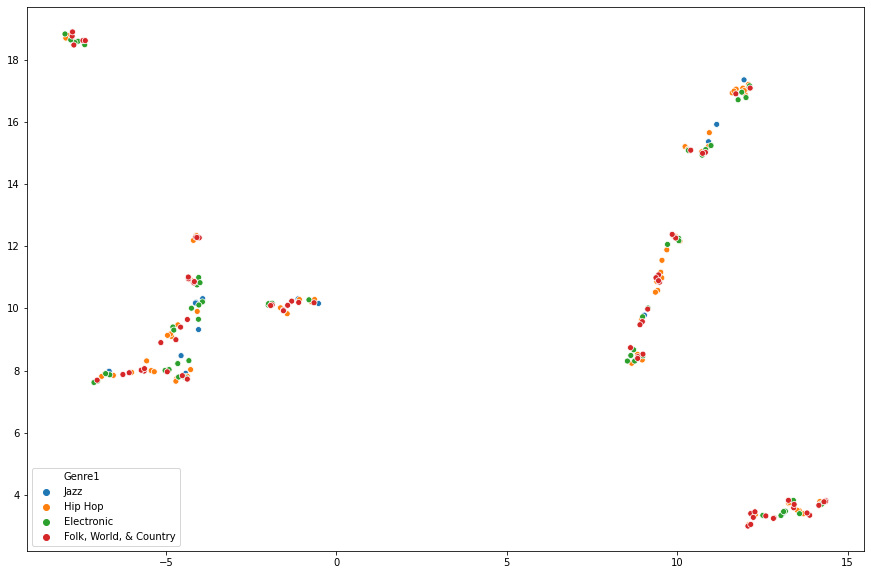

In [86]:
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

plt.figure(figsize=(15,10))
r = UMAP(n_components=2).fit_transform(embeddings)
sns.scatterplot(x=r[:,0], y=r[:,1], hue=data.Genre1)

AutoEncoder mit dem ganzen Datensatz

In [5]:
df.text

0       potato skins  potato cakes  hash browns  and i...
1       as i walk through the valley where i harvest m...
2       jillian was her name  she was sweeter than asp...
3       my mama told me when i was hatched  act like a...
4       here we go      here we go  one more time  eve...
                              ...                        
1033    you know i like my chicken fried  cold beer on...
1034    we never spoke a word  but every thought she h...
1035    well you're walking on the moon  but there's n...
1036    i lie awake  i've gone to ground  i'm watching...
1037    everybody's worried about time  but i just kee...
Name: text, Length: 1038, dtype: object

In [18]:
texts = df.text.to_list()

In [19]:
num_words = 1000
tk = Tokenizer(num_words=num_words, char_level=False, oov_token='UNK')

tk.fit_on_texts(texts)
sequences = tk.texts_to_sequences(texts)

char_dict = {char: index + 1 for index, char in enumerate(tk.word_index)}
char_dict[tk.oov_token] = max(char_dict.values()) + 1
tk.word_index = char_dict
n_letters = len(tk.word_index) + 1

In [20]:
maxlen = 500

sequences = pad_sequences(sequences=sequences, maxlen=maxlen, padding='post')

In [21]:
X = []

for entry in sequences:
    oh_entry = []
    for token_index in entry:
        oh = np.zeros(num_words, dtype='int8')
        oh[token_index] = 1
        oh_entry.append(oh)
    X.append(oh_entry)
X = np.asarray(X, dtype='int8')



In [22]:
X.shape, X.nbytes * 1e6

((1038, 500, 1000), 519000000000000.0)

In [24]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [98]:
#unser Modell
import keras 

recurrent_encoder = keras.models.Sequential([
    keras.layers.Embedding(num_words+1, 64, input_length=maxlen),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(maxlen, input_shape=[32]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation="sigmoid")),
    keras.layers.Flatten(),
    
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.1),
                     metrics=[rounded_accuracy])
recurrent_ae.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_34 (Sequential)   (None, 32)                109504    
_________________________________________________________________
sequential_35 (Sequential)   (None, 500)               8353      
Total params: 117,857
Trainable params: 117,857
Non-trainable params: 0
_________________________________________________________________


In [99]:
history = recurrent_ae.fit(sequences, sequences, epochs=10)
# history = recurrent_ae.fit(train_padded, train_padded, epochs=5, validation_data=(test_padded, test_padded))

Epoch 1/10
471/471 [==============================] - 15s 31ms/step - loss: 366912.4922 - rounded_accuracy: 0.1242
Epoch 2/10
471/471 [==============================] - 14s 29ms/step - loss: 366894.2484 - rounded_accuracy: 0.1405
Epoch 3/10
471/471 [==============================] - 14s 29ms/step - loss: 366893.8876 - rounded_accuracy: 0.1405
Epoch 4/10
471/471 [==============================] - 14s 29ms/step - loss: 366893.9820 - rounded_accuracy: 0.1405
Epoch 5/10
471/471 [==============================] - 14s 29ms/step - loss: 366894.2664 - rounded_accuracy: 0.1405
Epoch 6/10
471/471 [==============================] - 14s 29ms/step - loss: 366893.8322 - rounded_accuracy: 0.1405
Epoch 7/10
471/471 [==============================] - 14s 29ms/step - loss: 366893.1207 - rounded_accuracy: 0.1405
Epoch 8/10
471/471 [==============================] - 14s 29ms/step - loss: 366894.0461 - rounded_accuracy: 0.1405
Epoch 9/10
471/471 [==============================] - 14s 29ms/step - loss: 3668

In [100]:
embeddings = recurrent_encoder.predict(sequences)
print(embeddings.shape)
with open('autoencoder_embeddings.npy', 'wb') as f:
    np.save(f, embeddings)

(471, 32)


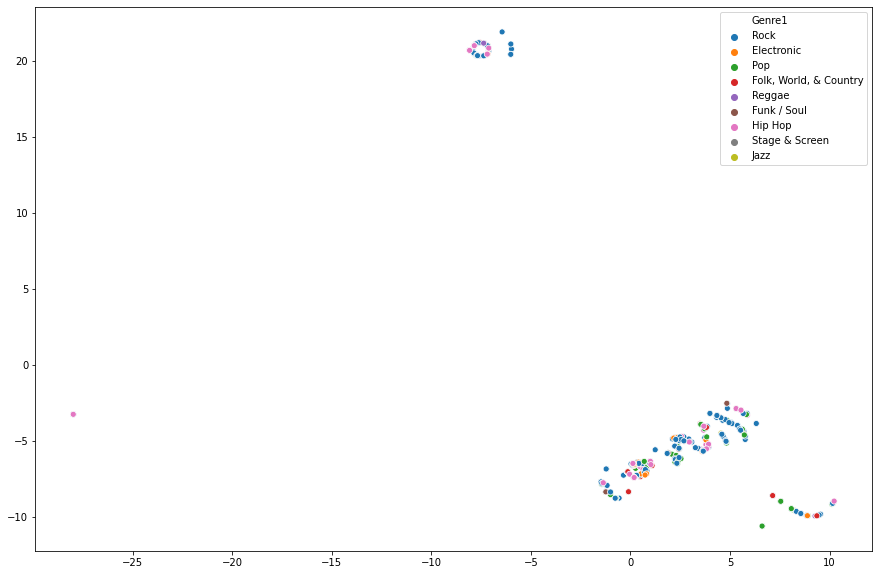

In [103]:
from umap import UMAP
from sklearn.decomposition import PCA
import seaborn as sns

plt.figure(figsize=(15,10))
r = TSNE(n_components=2).fit_transform(embeddings)
sns.scatterplot(x=r[:,0], y=r[:,1], hue=df.Genre1)

Lennarts Code (Mit angepasstem Model von Jan)

In [90]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import pandas as pd
import unicodedata
import string
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Nadam
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import SGD, Adam

In [91]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5474093327856618535
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11598079881482798974
physical_device_desc: "device: XLA_CPU device"
]


In [92]:
df.text = df.text.str.replace('\s+', ' ')

In [93]:
df['text_length'] = df.text.apply(lambda x: len(x.split()))
daf = df[df['text_length'] >= 3000]

In [94]:
daf.text_length

0       12745
1       10803
2        4352
5        3700
7        8618
        ...  
1028     4318
1029     5082
1030    10992
1031     3260
1034     5467
Name: text_length, Length: 471, dtype: int64

In [95]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters) +1 # for unknown token

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [96]:
texts = daf.text.apply(unicodeToAscii).to_list()

In [97]:
#Preprocessing(Keras)

num_words = 1000
tk = Tokenizer(num_words=num_words, char_level=False, oov_token='UNK')

tk.fit_on_texts(texts)
sequences = tk.texts_to_sequences(texts)

char_dict = {char: index + 1 for index, char in enumerate(tk.word_index)}
char_dict[tk.oov_token] = max(char_dict.values()) + 1
tk.word_index = char_dict
n_letters = len(tk.word_index) + 1



In [98]:
maxlen = 500

sequences = pad_sequences(sequences=sequences, maxlen=maxlen, padding='post')

In [99]:
X = []

for entry in sequences:
    oh_entry = []
    for token_index in entry:
        oh = np.zeros(num_words, dtype='int8')
        oh[token_index] = 1
        oh_entry.append(oh)
    X.append(oh_entry)
X = np.asarray(X, dtype='int8')

In [100]:
X.shape, X.nbytes * 1e6

((471, 500, 1000), 235500000000000.0)

In [101]:
def build_dense(num_words):
    
    stacked_encoder = Sequential([
        Input(shape=(num_words)),
        Dense(256, activation="linear"),
        Dense(128, activation="linear"),
    ])
    
    stacked_decoder = Sequential([
        Dense(128, activation='linear', input_shape=[128]),
        Dense(256, activation="linear"),
        Dense(num_words, activation="sigmoid")
    ])
    stacked_ae = Sequential([stacked_encoder, stacked_decoder])
    stacked_ae.compile(loss="binary_crossentropy",
    optimizer=Adam(lr=0.01))
    return stacked_ae, stacked_encoder

In [102]:
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.models import Model

def build_recurrent_model(n_letters, maxlen):
    encoder = Sequential([
        Input(shape=(maxlen,)),
        Embedding(n_letters, 32),
        LSTM(32,
             return_sequences=True,
            ),
        LSTM(16,
             return_sequences=False,
            ),
    ])
    decoder = Sequential([
        RepeatVector(maxlen),
        LSTM(16,
             return_sequences=True,
            ),
        TimeDistributed(Dense(n_letters, activation='sigmoid'))
    ])
    autoencoder = Sequential([encoder, decoder])
    autoencoder.compile(loss='mse', optimizer='rmsprop')
    return autoencoder, encoder

In [103]:
callbacks = [
    ModelCheckpoint(filepath='../Results/autoencoder/model.{epoch:02d}-{loss:.2f}.h5',
                    monitor='loss',
                    save_best_only=True,
                    save_freq=5),
    TensorBoard(log_dir='../Results/tensorboard_logs',
                embeddings_freq=1)
]

In [104]:
recurrent_autoencoder, recurrent_encoder = build_recurrent_model(num_words, maxlen)
recurrent_autoencoder.summary()
recurrent_encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 16)                43456     
_________________________________________________________________
sequential_1 (Sequential)    (None, 500, 1000)         19112     
Total params: 62,568
Trainable params: 62,568
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           32000     
_________________________________________________________________
lstm (LSTM)                  (None, 500, 32)           8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
Total params: 43,456
Trainable

In [105]:
history = recurrent_autoencoder.fit(sequences, X, batch_size=64, epochs=10, callbacks=callbacks)

Epoch 1/10
8/8 [==============================] - 8s 968ms/step - loss: 0.2444
Epoch 2/10
8/8 [==============================] - 8s 969ms/step - loss: 0.2056
Epoch 3/10
8/8 [==============================] - 8s 976ms/step - loss: 0.1676
Epoch 4/10
8/8 [==============================] - 8s 950ms/step - loss: 0.1374
Epoch 5/10
8/8 [==============================] - 8s 956ms/step - loss: 0.1134
Epoch 6/10
8/8 [==============================] - 8s 948ms/step - loss: 0.0935
Epoch 7/10
8/8 [==============================] - 8s 938ms/step - loss: 0.0768
Epoch 8/10
8/8 [==============================] - 8s 948ms/step - loss: 0.0631
Epoch 9/10
8/8 [==============================] - 8s 947ms/step - loss: 0.0519
Epoch 10/10
8/8 [==============================] - 8s 944ms/step - loss: 0.0427


In [106]:
print(embeddings.shape)
with open('autoencoder_embeddings.npy', 'wb') as f:
    np.save(f, embeddings)

(209, 32)


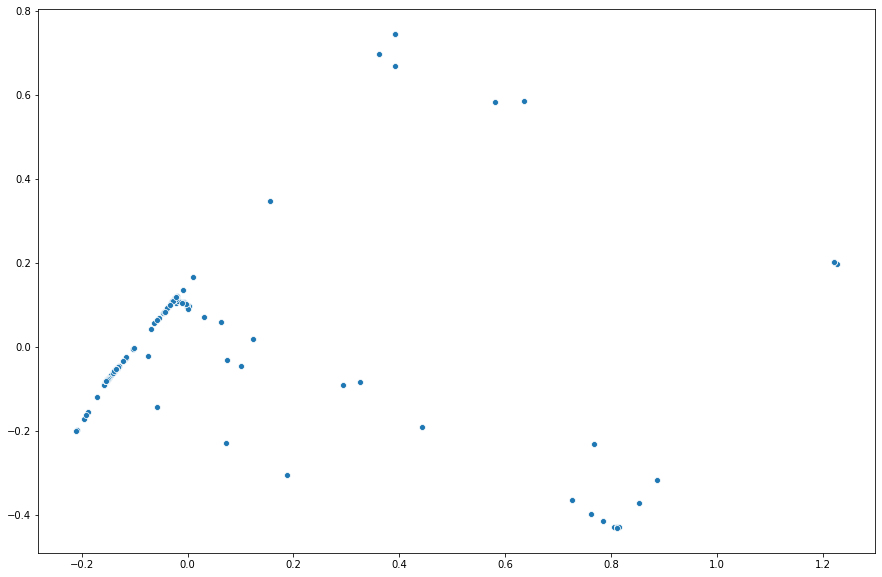

In [112]:
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

#plt.figure(figsize=(30,20))
#r = UMAP(n_components=2).fit_transform(embeddings)
#sns.scatterplot(x=r[:,0], y=r[:,1], hue=df.Genre1)

plt.figure(figsize=(15, 10))
r = PCA(n_components=2).fit_transform(embeddings)
sns.scatterplot(x=r[:,0], y=r[:,1])

In [109]:
df.head(10)

,Unnamed: 0,artist,decades,text,stemmed_text,POS,Genre1,genre1,number_of_tokens,number_of_types,text_length
0,0,"""Weird Al"" Yankovic",1980s,potato skins potato cakes hash browns and inst...,potato skin potato cake hash brown and instan...,french plain enough greasy sour lumpy tough en...,Rock,antiviral pop,12745.0,2264.0,12745
1,37,"""Weird Al"" Yankovic",1990s,as i walk through the valley where i harvest m...,as i walk through the valley where i harvest ...,plain perfect fancy amish amish hard amish ami...,Rock,antiviral pop,10803.0,2317.0,10803
2,65,"""Weird Al"" Yankovic",2000s,jillian was her name she was sweeter than aspa...,jillian wa her name she wa sweeter than aspar...,same gorgeous perfect close sweet young ripe p...,Rock,antiviral pop,4352.0,1159.0,4352
3,76,"""Weird Al"" Yankovic",2010s,my mama told me when i was hatched act like a ...,my mama told me when i wa hatch act like a su...,red hard sure swiss crazy little okay crazy ev...,Rock,antiviral pop,2077.0,705.0,2077
4,81,*NSYNC,1990s,here we go here we go one more time everybody'...,here we go here we go one more time everybodi...,fine fine free right fine right fine free time...,Electronic,boy band,1786.0,345.0,1786
5,87,*NSYNC,2000s,this is the time of year that we learn to give...,thi is the time of year that we learn to give...,true hard alone dark true true true time year ...,Electronic,boy band,3700.0,548.0,3700
6,98,*NSYNC,2010s,girl don't say that it's over 'cause you are a...,girl do n't say that it 's over 'caus you are...,wrong lonely beautiful beautiful beautiful bea...,Electronic,boy band,1499.0,299.0,1499
7,102,ABBA,1970s,i'll never know why i had to go why i had to p...,i 'll never know whi i had to go whi i had to...,lousy rotten tough enough good new good new ne...,Pop,europop,8618.0,1070.0,8618
8,130,ABBA,1980s,take it easy with me please touch me gently li...,take it easi with me pleas touch me gentli li...,easy slow andante soft light andante strong st...,Pop,europop,5963.0,1131.0,5963
9,154,Adam Sandler,1990s,i'm sitting in my chair watching the tv it's ...,i 'm sit in my chair watch the tv it 's not e...,crazy wicked last sweet baked chair tv plenty ...,Rock,comedy,7421.0,2201.0,7421


In [65]:
embeddings.std(axis=0)

array([2.1816943e-06, 1.4802617e-02, 5.0274910e-05, 5.8030717e-05,
       1.7512744e-05, 6.8370737e-06, 2.9528709e-04, 5.6989069e-07,
       6.7792564e-05, 2.6173890e-05, 3.2219268e-05, 2.2368191e-08,
       2.4192597e-09, 6.5313543e-08, 1.0001689e-07, 6.2715316e-08],
      dtype=float32)

In [66]:
embeddings

array([[-8.0815212e-09,  7.7167088e-01,  9.9999011e-01, ...,
         2.6746208e-10,  3.0489380e-10,  3.9447876e-11],
       [-8.3007506e-10,  7.6472372e-01,  9.9999511e-01, ...,
         3.0927982e-11,  2.9255598e-11,  2.2221198e-12],
       [-1.6901050e-10,  7.6250803e-01,  9.9999714e-01, ...,
         1.1494129e-11,  4.4197298e-12,  3.8751034e-13],
       ...,
       [-4.2134113e-10,  7.6206791e-01,  9.9999511e-01, ...,
         5.0481272e-11,  1.8267464e-11,  1.7619015e-12],
       [-3.7576647e-10,  7.6217997e-01,  9.9999535e-01, ...,
         4.0212448e-11,  1.5034382e-11,  1.4171648e-12],
       [-3.8754830e-10,  7.6209104e-01,  9.9999511e-01, ...,
         4.2465309e-11,  1.5837795e-11,  1.4670386e-12]], dtype=float32)

AutoEncoder mit altem komplettem Datensatz

In [4]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/songtexte_bereinigt_gekuerzt.csv')

In [5]:
df.head(2)

,Unnamed: 0,artist,song,text,number_of_tokens
0,0,ABBA,Ahe's My Kind Of Girl,look at her face it's a wonderful face and i...,741
1,1,ABBA,"Andante, Andante",take it easy with me please touch me gently ...,1381


In [6]:
texts = df.text.to_list()

In [7]:
num_words = 500
tk = Tokenizer(num_words=num_words, char_level=False, oov_token='UNK')

tk.fit_on_texts(texts)
sequences = tk.texts_to_sequences(texts)

char_dict = {char: index + 1 for index, char in enumerate(tk.word_index)}
char_dict[tk.oov_token] = max(char_dict.values()) + 1
tk.word_index = char_dict
n_letters = len(tk.word_index) + 1

In [8]:
maxlen = 200

sequences = pad_sequences(sequences=sequences, maxlen=maxlen, padding='post')

In [9]:
X = []

for entry in sequences:
    oh_entry = []
    for token_index in entry:
        oh = np.zeros(num_words, dtype='int8')
        oh[token_index] = 1
        oh_entry.append(oh)
    X.append(oh_entry)
X = np.asarray(X, dtype='int8')

In [10]:
X.shape, X.nbytes * 1e6

((50832, 200, 500), 5083200000000000.0)

In [12]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [13]:
import keras 

recurrent_encoder = keras.models.Sequential([
    keras.layers.Embedding(num_words+1, 64, input_length=maxlen),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(maxlen, input_shape=[32]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation="sigmoid")),
    keras.layers.Flatten(),
    
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.1),
                     metrics=[rounded_accuracy])
recurrent_ae.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 32)                77504     
_________________________________________________________________
sequential_2 (Sequential)    (None, 200)               8353      
Total params: 85,857
Trainable params: 85,857
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = recurrent_ae.fit(sequences, sequences, epochs=10)

Epoch 1/10
50832/50832 [==============================] - 529s 10ms/step - loss: 64195.4706 - rounded_accuracy: 0.1444
Epoch 2/10
50832/50832 [==============================] - 543s 11ms/step - loss: 64230.5560 - rounded_accuracy: 0.1704
Epoch 3/10
50832/50832 [==============================] - 548s 11ms/step - loss: 64230.4773 - rounded_accuracy: 0.1791
Epoch 4/10
50832/50832 [==============================] - 548s 11ms/step - loss: 64230.4766 - rounded_accuracy: 0.1791
Epoch 5/10
50832/50832 [==============================] - 546s 11ms/step - loss: 64230.4754 - rounded_accuracy: 0.1791
Epoch 6/10
50832/50832 [==============================] - 547s 11ms/step - loss: 64230.4760 - rounded_accuracy: 0.1791
Epoch 7/10
50832/50832 [==============================] - 544s 11ms/step - loss: 64230.4782 - rounded_accuracy: 0.1791
Epoch 8/10
50832/50832 [==============================] - 540s 11ms/step - loss: 64230.4764 - rounded_accuracy: 0.1791
Epoch 9/10
50832/50832 [========================

In [15]:
embeddings = recurrent_encoder.predict(sequences)
print(embeddings.shape)
with open('autoencoder_embeddings.npy', 'wb') as f:
    np.save(f, embeddings)

(50832, 32)


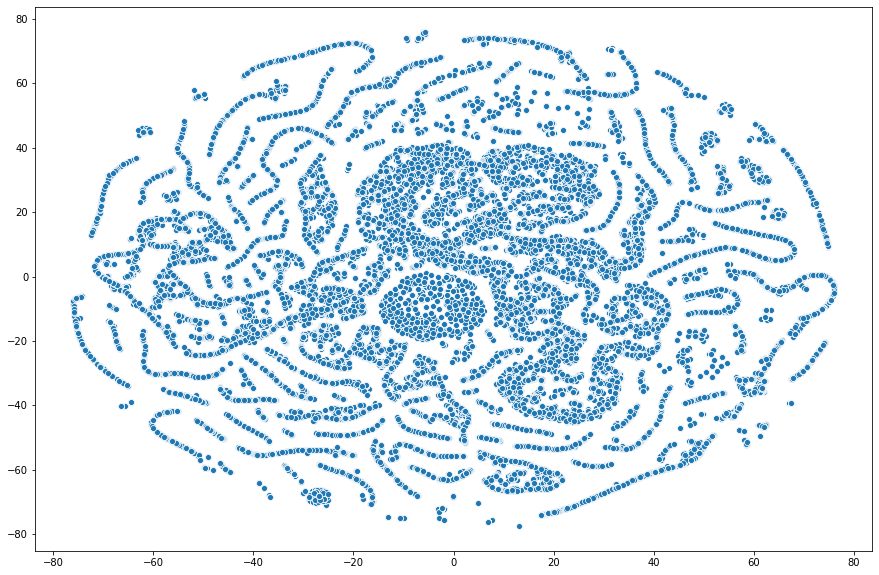

In [16]:
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

plt.figure(figsize=(15,10))
r = TSNE(n_components=2).fit_transform(embeddings)
sns.scatterplot(x=r[:,0], y=r[:,1])